### Package Importing

In [1]:
# Importing all the required packages for this task

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
# from sklearn import metrics


In [3]:
# # import nltk
# # nltk.download('wordnet')
# pip install 

In [41]:
# Natural Language Processing Toolkit
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
# from nltk.stem import PorterStemmer (I played around with Stemmer and decided to use Lemmatizer instead)
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from nltk import pos_tag # For Parts of Speech tagging
import string # Inbuilt string library
from emot.emo_unicode import UNICODE_EMOJI
# WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image # for opening, manipulating, and saving many different image file f
from textblob import TextBlob # TextBlob - Python library for processing textual data
import matplotlib.pyplot as plt
import random 
import pickle
import re




In [4]:
tweets_df = pd.read_csv("clean_processed_tweet_data.csv")

In [5]:
tweets_df.head()

,Unnamed: 0,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,38,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,188,43,davideiacovozzi,18,55,NaN,"gold, silver, crypto",NorthstarCharts,NaN
1,39,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175000,en,179,32,davideiacovozzi,18,55,NaN,NaN,MichaelAArouet,NaN
2,41,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,193,26,davideiacovozzi,18,55,False,NaN,goldseek,NaN
3,42,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,620,213,davideiacovozzi,18,55,NaN,NaN,charliebilello,NaN
4,43,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,1787,417,davideiacovozzi,18,55,False,NaN,biancoresearch,NaN


#### Data Understanding Management

In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16472 entries, 0 to 16471
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          16472 non-null  int64  
 1   created_at          16472 non-null  object 
 2   source              16472 non-null  object 
 3   original_text       16472 non-null  object 
 4   polarity            16472 non-null  float64
 5   subjectivity        16472 non-null  float64
 6   lang                16472 non-null  object 
 7   favorite_count      16472 non-null  int64  
 8   retweet_count       16472 non-null  int64  
 9   original_author     16472 non-null  object 
 10  followers_count     16472 non-null  int64  
 11  friends_count       16472 non-null  int64  
 12  possibly_sensitive  6206 non-null   object 
 13  hashtags            5278 non-null   object 
 14  user_mentions       12165 non-null  object 
 15  place               10765 non-null  object 
dtypes: f

In [7]:
tweets_df.shape #Get number of rows and columns

(16472, 16)

In [8]:
# Check the number of missing values

print("The number of missing value(s): {}".format(tweets_df.isnull().sum().sum()))
print("Columons having columns value:{}".format(tweets_df.columns[tweets_df.isnull().any()]))

The number of missing value(s): 31474
Columons having columns value:Index(['possibly_sensitive', 'hashtags', 'user_mentions', 'place'], dtype='object')


In [9]:
tweets_df.isna().any() # Check for "NaN" values

Unnamed: 0            False
created_at            False
source                False
original_text         False
polarity              False
subjectivity          False
lang                  False
favorite_count        False
retweet_count         False
original_author       False
followers_count       False
friends_count         False
possibly_sensitive     True
hashtags               True
user_mentions          True
place                  True
dtype: bool

In [10]:
tweets_df['place']=tweets_df['place'].fillna('No place') # Replace "NaN" values with "No Location"
tweets_df['possibly_sensitive']=tweets_df['possibly_sensitive'].fillna('Neutral') # Replace "NaN" values with "possibly_sensitive"
tweets_df['hashtags']=tweets_df['hashtags'].fillna('No hashtags') # Replace "NaN" values with "hashtags"
tweets_df['user_mentions']=tweets_df['user_mentions'].fillna('No user mention') # Replace "NaN" values with "user_mentions"

In [11]:
tweets_df.isna().any() # Check for "NaN" values again

Unnamed: 0            False
created_at            False
source                False
original_text         False
polarity              False
subjectivity          False
lang                  False
favorite_count        False
retweet_count         False
original_author       False
followers_count       False
friends_count         False
possibly_sensitive    False
hashtags              False
user_mentions         False
place                 False
dtype: bool

In [12]:
# Function to remove punctuations, links, emojis, and stop words
def preprocessTweets(tweet):
    tweet = tweet.lower()  #has to be in place
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)  # convert string to tokens
    filtered_words = [w for w in tweet_tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emojis]
    filtered_words = [w for w in filtered_words if w in word_list]

    # Remove punctuations
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words)  # join words with a space in between them


# function to obtain adjectives from tweets
def getAdjectives(tweet):
    tweet = word_tokenize(tweet)  # convert string to tokens
    tweet = [word for (word, tag) in pos_tag(tweet)
             if tag == "JJ"]  # pos_tag module in NLTK library
    return " ".join(tweet)  # join words with a space in between them

In [13]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
user_stop_words = ['2022', 'year', 'many', 'much', 'next', 'cant', 'wont', 'hadnt',
                    'havent', 'hasnt', 'isnt', 'shouldnt', 'couldnt', 'wasnt', 'werent',
                    'mustnt', '’', '...', '..', '.', '.....', '....', 'been…', 'one', 'two',
                    'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'aht',
                    've', 'next']
alphabets = list(string.ascii_lowercase)
stop_words = stop_words + user_stop_words + alphabets
word_list = words.words()  # all words in English language
emojis = list(UNICODE_EMOJI.keys())  # full list of emojis

In [14]:
print(preprocessTweets("2022 was a year of difficulty. It was sad, but I am happy with how things worked out for me"))

difficulty sad happy worked


In [15]:
# Apply preProcessTweets function to the 'Tweet' column to generate a new column called 'Processed Tweets'.
tweets_df['Processed_Tweets'] = tweets_df['original_text'].apply(preprocessTweets)

In [ ]:
# import nltk
# nltk.download('averaged_perceptron_tagger')

In [ ]:
# Apply getAdjectives function to the new 'Processed Tweets' column to generate a new column called 'Tweets_Adjectives'
tweets_df['Tweets_Adjectives'] = tweets_df['Processed_Tweets'].apply(getAdjectives)

In [ ]:
tweets_df.head() # Check dataframe first 5 rows

,Unnamed: 0,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,Processed_Tweets,Tweets_Adjectives
0,38,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,188,43,davideiacovozzi,18,55,Neutral,"gold, silver, crypto",NorthstarCharts,No place,yield telling us high risk something system go...,high
1,39,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175000,en,179,32,davideiacovozzi,18,55,Neutral,No hashtags,MichaelAArouet,No place,german mortgage rate went hear sound german re...,german hear sound german real
2,41,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,193,26,davideiacovozzi,18,55,False,No hashtags,goldseek,No place,,
3,42,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,620,213,davideiacovozzi,18,55,Neutral,No hashtags,charliebilello,No place,mortgage rate us highest level since last hit low,last low
4,43,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,1787,417,davideiacovozzi,18,55,False,No hashtags,biancoresearch,No place,rise something anything broken yet,broken


In [33]:
# function to return words to their base form using Lemmatizer
def preprocessTweetsSentiments(tweet):
    tweet_tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer() # instatiate an object WordNetLemmatizer Class
    lemma_words = [lemmatizer.lemmatize(w) for w in tweet_tokens]
    return " ".join(lemma_words)

In [34]:

# Apply preprocessTweetsSentiments function to the 'Processed Tweets' column to generate a new column
# called 'Processed_Tweets'
tweets_df['Tweets_Sentiments'] = tweets_df['Processed_Tweets'].apply(preprocessTweetsSentiments)

In [20]:
# Apply getAdjectives function to the new 'Processed Tweets' column to generate a new column called 'Tweets_Adjectives'
tweets_df['Tweets_Adjectives'] = tweets_df['Processed_Tweets'].apply(getAdjectives)

In [36]:
tweets_df.head()

,Unnamed: 0,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,...,possibly_sensitive,hashtags,user_mentions,place,Processed_Tweets,Tweets_Adjectives,Tweets_Sentiments,Subjectivity,Polarity,Sentiment
0,38,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,188,43,davideiacovozzi,...,Neutral,"gold, silver, crypto",NorthstarCharts,No place,yield telling us high risk something system go...,high,yield telling u high risk something system gol...,0.540000,0.16,Positive
1,39,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175000,en,179,32,davideiacovozzi,...,Neutral,No hashtags,MichaelAArouet,No place,german mortgage rate went hear sound german re...,german hear sound german real,german mortgage rate went hear sound german re...,0.175000,0.15,Positive
2,41,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,193,26,davideiacovozzi,...,False,No hashtags,goldseek,No place,,,,0.000000,0.00,Neutral
3,42,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,620,213,davideiacovozzi,...,Neutral,No hashtags,charliebilello,No place,mortgage rate us highest level since last hit low,last low,mortgage rate u highest level since last hit low,0.183333,0.00,Neutral
4,43,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,1787,417,davideiacovozzi,...,False,No hashtags,biancoresearch,No place,rise something anything broken yet,broken,rise something anything broken yet,0.400000,-0.40,Negative


In [18]:
# Write the results to a csv file  

tweets_df.to_csv('Tweets_Processed.csv',encoding='utf-8-sig', index=False)

In [22]:
# Extract all tweets into one long string with each word separate with a "space"
tweets_long_string = tweets_df['Tweets_Adjectives'].tolist()
tweets_long_string = " ".join(tweets_long_string)

In [23]:
# Create function to generate the blue colour for the Word CLoud

def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

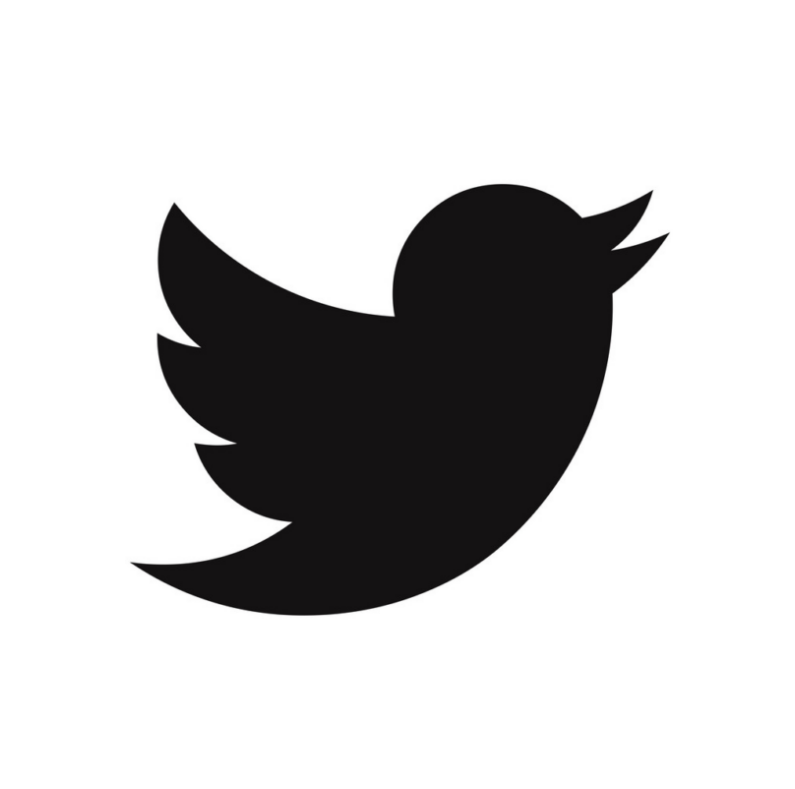

In [25]:
# Import Twitter Logo
image = np.array(Image.open('twitter.png'))
    
fig = plt.figure() # Instantiate the figure object
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(image, cmap=plt.cm.gray, interpolation='bilinear') # Display data as an image
plt.axis('off') # Remove axis
plt.show() # Display image

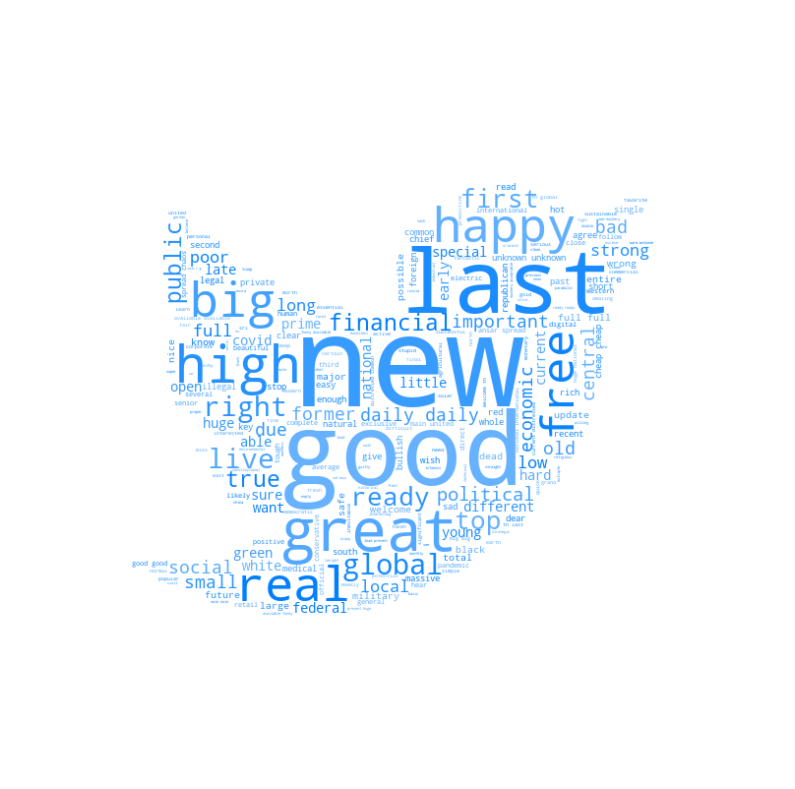

In [29]:
# Instantiate the Twitter word cloud object
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

# generate the word cloud
twitter_wc.generate(tweets_long_string)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

### Sentiment Analysis

In [30]:
# Create function to obtain Subjectivity Score
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# Create function to obtain Polarity Score
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Create function to obtain Sentiment category
def getSentimentTextBlob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

In [35]:
# Apply all functions above to respective columns
tweets_df['Subjectivity']=tweets_df['Tweets_Sentiments'].apply(getSubjectivity)
tweets_df['Polarity']=tweets_df['Tweets_Sentiments'].apply(getPolarity)
tweets_df['Sentiment']=tweets_df['Polarity'].apply(getSentimentTextBlob)

In [37]:
# See quick results of the Sentiment Analysis
tweets_df['Sentiment'].value_counts()

Neutral     8552
Positive    5594
Negative    2326
Name: Sentiment, dtype: int64

In [38]:
# Create dataframe for Count of Sentiment Categories
bar_chart = tweets_df['Sentiment'].value_counts().rename_axis('Sentiment').to_frame('Total Tweets').reset_index()

In [39]:
bar_chart # Display dataframe

,Sentiment,Total Tweets
0,Neutral,8552
1,Positive,5594
2,Negative,2326


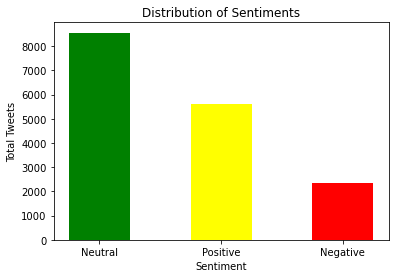

In [40]:
x = bar_chart['Sentiment']
y = bar_chart['Total Tweets']
c = ["green", "yellow", "red"]
plt.bar(x, y, width=0.5, color=c)
plt.xlabel("Sentiment")
plt.ylabel("Total Tweets")
plt.title("Distribution of Sentiments")
plt.show()


#### Score

In [62]:
clean_tweet = tweets_df[['Tweets_Sentiments','polarity']]

In [63]:
clean_tweet.head(5)

,Tweets_Sentiments,polarity
0,yield telling u high risk something system gol...,0.16
1,german mortgage rate went hear sound german re...,0.15
2,,0.00
3,mortgage rate u highest level since last hit low,0.00
4,rise something anything broken yet,-0.40


In [64]:
score = pd.Series([getSentimentTextBlob(row_value) for row_value in clean_tweet['polarity']])

In [65]:
clean_tweet = pd.concat([clean_tweet, score.rename("score")], axis=1)

In [66]:
clean_tweet.head(n=10)

,Tweets_Sentiments,polarity,score
0,yield telling u high risk something system gol...,0.160000,Positive
1,german mortgage rate went hear sound german re...,0.150000,Positive
2,,0.000000,Neutral
3,mortgage rate u highest level since last hit low,0.000000,Neutral
4,rise something anything broken yet,-0.400000,Negative
5,like occur every,-0.100000,Negative
6,welcome bond testing risk asset private sector...,0.400000,Positive
7,horse thing another,0.000000,Neutral
8,global growth optimism time raise time see,0.488281,Positive
9,important chart world demand outlook demand so...,0.450000,Positive


In [67]:
len(clean_tweet['polarity'])

16472

In [68]:
scoremap = pd.Series([1 if row_value == 'Positive' else 0 for row_value in clean_tweet['score']])

In [69]:
len(scoremap)

16472

In [70]:
clean_tweet['scoremap'] = scoremap
X = clean_tweet['Tweets_Sentiments']
y = clean_tweet['scoremap']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
print(X_train.size,',' , X_test.size)
print(X_test.size, ',',y_test.size)

13177 , 3295
3295 , 3295


In [73]:
# scaling the input
clf = LinearSVC()

In [74]:
unigram_tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range = (1, 1))
bigram_tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range = (2, 2))
hybrid_tfidf_vect = TfidfVectorizer(max_features=10000, ngram_range = (1, 2))

## Unigram TF-IDF

In [75]:
X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = unigram_tfidf_vect.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
clf.fit(X_train_counts, y_train)

LinearSVC()

In [76]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = unigram_tfidf_vect.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)

In [77]:
np.mean(prediction == y_test)

0.8819423368740515

## Bigram TF-IDF

In [78]:
X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = bigram_tfidf_vect.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
clf.fit(X_train_counts, y_train)

LinearSVC()

In [79]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = bigram_tfidf_vect.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)

In [80]:
np.mean(prediction == y_test)

0.7220030349013657

## Hybridgram TF-IDF

In [81]:
# X_train = X_train.replace(np.nan, '', regex=True)
X_train_counts = hybrid_tfidf_vect.fit_transform(X_train)
X_train_counts = X_train_counts.toarray()
model = clf.fit(X_train_counts, y_train)

LinearSVC()

In [82]:
X_test = X_test.replace(np.nan, '', regex=True)
X_test_counts = hybrid_tfidf_vect.transform(X_test)
X_test_counts = X_test_counts.toarray()
prediction = clf.predict(X_test_counts)

In [83]:
np.mean(prediction == y_test)

0.8852807283763278

### Save the Model

In [ ]:
pickle.dump(model, open('model.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(y_test)